In [1]:
# Importujeme knihovny
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Načtěme soubor a připojime SQL
dbfile = "C:\\Users\\kjevh\\Downloads\\chinook.db"
conn = sqlite3.connect(dbfile)
cursor = conn.cursor()

In [3]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print(f"TABLE Name: {tables}")

TABLE Name: [('album',), ('artist',), ('customer',), ('employee',), ('genre',), ('invoice',), ('invoice_line',), ('media_type',), ('playlist',), ('playlist_track',), ('track',)]


In [4]:
# Vytvořme tabulku
result = [a for a in cursor.execute("SELECT invoice_id, invoice_date, customer_id, c.track_id, genre_type, c.unit_price \
                                      FROM \
                                        (SELECT a.invoice_id, invoice_date, customer_id, track_id, unit_price \
                                          FROM \
                                            (SELECT invoice_id, invoice_date, customer_id \
                                             FROM invoice \
                                               WHERE strftime('%Y', invoice_date) == '2020') AS a \
                                             JOIN (SELECT * from invoice_line) AS b \
                                             ON a.invoice_id = b.invoice_id) AS c \
                                          JOIN \
                                             (SELECT * \
                                             FROM track as a \
                                             JOIN (SELECT * FROM media_type \
                                                   WHERE name LIKE '%audio%')as b \
                                             ON a.media_type_id== b.media_type_id \
                                             JOIN (SELECT *,\
                                                      CASE    \
                                                        WHEN name = 'Rock' OR name = 'Alternative & Punk' OR name = 'Metal' \
                                                        OR name = 'Alternative' OR name = 'Heavy Metal' THEN 'rock'\
                                                        ELSE 'others’' \
                                                      END AS genre_type \
                                                    FROM genre) as c \
                                             ON a.genre_id== c.genre_id) AS d \
                                          ON c.track_id = d.track_id \
                     ")]

In [5]:
# Vytvoření datového rámce na základě požadavku
df = pd.read_sql_query("SELECT invoice_id, invoice_date, customer_id, c.track_id, genre_type, c.unit_price \
                                      FROM \
                                        (SELECT a.invoice_id, invoice_date, customer_id, track_id, unit_price \
                                          FROM \
                                            (SELECT invoice_id, invoice_date, customer_id \
                                             FROM invoice \
                                               WHERE strftime('%Y', invoice_date) == '2020') AS a \
                                             JOIN (SELECT * from invoice_line) AS b \
                                             ON a.invoice_id = b.invoice_id) AS c \
                                          JOIN \
                                             (SELECT * \
                                             FROM track as a \
                                             JOIN (SELECT * FROM media_type \
                                                   WHERE name LIKE '%audio%')as b \
                                             ON a.media_type_id== b.media_type_id \
                                             JOIN (SELECT *,\
                                                      CASE    \
                                                        WHEN name = 'Rock' OR name = 'Alternative & Punk' OR name = 'Metal' \
                                                        OR name = 'Alternative' OR name = 'Heavy Metal' THEN 'rock'\
                                                        ELSE 'others’' \
                                                      END AS genre_type \
                                                    FROM genre) as c \
                                             ON a.genre_id== c.genre_id) AS d \
                                          ON c.track_id = d.track_id \
                     ", conn)
conn.close()

In [6]:
df

,invoice_id,invoice_date,customer_id,track_id,genre_type,unit_price
0,465,2020-01-12 00:00:00,21,149,rock,0.99
1,465,2020-01-12 00:00:00,21,150,rock,0.99
2,465,2020-01-12 00:00:00,21,151,rock,0.99
3,465,2020-01-12 00:00:00,21,152,rock,0.99
4,465,2020-01-12 00:00:00,21,153,rock,0.99
...,...,...,...,...,...,...
1145,614,2020-12-30 00:00:00,53,2659,rock,0.99
1146,614,2020-12-30 00:00:00,53,2660,rock,0.99
1147,614,2020-12-30 00:00:00,53,2661,rock,0.99
1148,614,2020-12-30 00:00:00,53,2662,rock,0.99


In [7]:
# Zkontrolujte, zda datový rámec neobsahuje mezery a duplikaty
missing_values = df.isnull().sum() 
print("Пропуски в DataFrame:\n", missing_values)

Пропуски в DataFrame:
 invoice_id      0
invoice_date    0
customer_id     0
track_id        0
genre_type      0
unit_price      0
dtype: int64


In [8]:
duplicates = df.duplicated().sum() 
print("Počet duplikatu v datovém rámci:", duplicates)

Počet duplikatu v datovém rámci: 2


In [9]:
# Vyhledání duplikátu
duplicates = df[df.duplicated()] 
print("Duplikáty v DataFrame:") 
print(duplicates)

Duplikáty v DataFrame:
     invoice_id         invoice_date  customer_id  track_id genre_type  \
382         517  2020-05-16 00:00:00            3      2573    others’   
997         593  2020-11-23 00:00:00           12      1042    others’   

     unit_price  
382        0.99  
997        0.99  


In [10]:
# Odstraňme duplikaty
df_unique = df.drop_duplicates() 
print("DataFrame bez duplikatu:") 
print(df_unique)

DataFrame bez duplikatu:
      invoice_id         invoice_date  customer_id  track_id genre_type  \
0            465  2020-01-12 00:00:00           21       149       rock   
1            465  2020-01-12 00:00:00           21       150       rock   
2            465  2020-01-12 00:00:00           21       151       rock   
3            465  2020-01-12 00:00:00           21       152       rock   
4            465  2020-01-12 00:00:00           21       153       rock   
...          ...                  ...          ...       ...        ...   
1145         614  2020-12-30 00:00:00           53      2659       rock   
1146         614  2020-12-30 00:00:00           53      2660       rock   
1147         614  2020-12-30 00:00:00           53      2661       rock   
1148         614  2020-12-30 00:00:00           53      2662       rock   
1149         614  2020-12-30 00:00:00           53      2663       rock   

      unit_price  
0           0.99  
1           0.99  
2           0.99 

In [11]:
# Přenesme datum na první den každého měsíce
df_unique['invoice_date'] = pd.to_datetime(df['invoice_date']).dt.to_period('M').dt.to_timestamp() 
print(df_unique)

      invoice_id invoice_date  customer_id  track_id genre_type  unit_price
0            465   2020-01-01           21       149       rock        0.99
1            465   2020-01-01           21       150       rock        0.99
2            465   2020-01-01           21       151       rock        0.99
3            465   2020-01-01           21       152       rock        0.99
4            465   2020-01-01           21       153       rock        0.99
...          ...          ...          ...       ...        ...         ...
1145         614   2020-12-01           53      2659       rock        0.99
1146         614   2020-12-01           53      2660       rock        0.99
1147         614   2020-12-01           53      2661       rock        0.99
1148         614   2020-12-01           53      2662       rock        0.99
1149         614   2020-12-01           53      2663       rock        0.99

[1148 rows x 6 columns]


In [12]:
# Seskuptme data a seřaděme je podle žánru (‘rock’ и ‘others’) další měsíční ukazatele:
# celkový počet zakoupených skladeb
tracks_count = df_unique.groupby(['invoice_date', 'genre_type']).size().reset_index(name='tracks_count')
tracks_count

,invoice_date,genre_type,tracks_count
0,2020-01-01,others’,6
1,2020-01-01,rock,38
2,2020-02-01,others’,5
3,2020-02-01,rock,93
4,2020-03-01,others’,21
5,2020-03-01,rock,58
6,2020-04-01,others’,15
7,2020-04-01,rock,106
8,2020-05-01,others’,16
9,2020-05-01,rock,66


In [13]:
# počet šeků
invoices_count = df_unique.groupby(['invoice_date', 'genre_type'])['invoice_id'].nunique().reset_index(name='invoices_count')
invoices_count

,invoice_date,genre_type,invoices_count
0,2020-01-01,others’,3
1,2020-01-01,rock,8
2,2020-02-01,others’,4
3,2020-02-01,rock,11
4,2020-03-01,others’,6
5,2020-03-01,rock,10
6,2020-04-01,others’,8
7,2020-04-01,rock,15
8,2020-05-01,others’,8
9,2020-05-01,rock,13


In [14]:
# počet kupujících
customers_count = df_unique.groupby(['invoice_date', 'genre_type'])['customer_id'].nunique().reset_index(name='customers_count')
customers_count

,invoice_date,genre_type,customers_count
0,2020-01-01,others’,3
1,2020-01-01,rock,8
2,2020-02-01,others’,4
3,2020-02-01,rock,11
4,2020-03-01,others’,6
5,2020-03-01,rock,10
6,2020-04-01,others’,8
7,2020-04-01,rock,15
8,2020-05-01,others’,7
9,2020-05-01,rock,11


In [15]:
# celkové náklady skladeb
total_amount = df_unique.groupby(['invoice_date', 'genre_type'])['unit_price'].sum().reset_index(name='total_amount')
total_amount                                                                                                 

,invoice_date,genre_type,total_amount
0,2020-01-01,others’,5.94
1,2020-01-01,rock,37.62
2,2020-02-01,others’,4.95
3,2020-02-01,rock,92.07
4,2020-03-01,others’,20.79
5,2020-03-01,rock,57.42
6,2020-04-01,others’,14.85
7,2020-04-01,rock,104.94
8,2020-05-01,others’,15.84
9,2020-05-01,rock,65.34


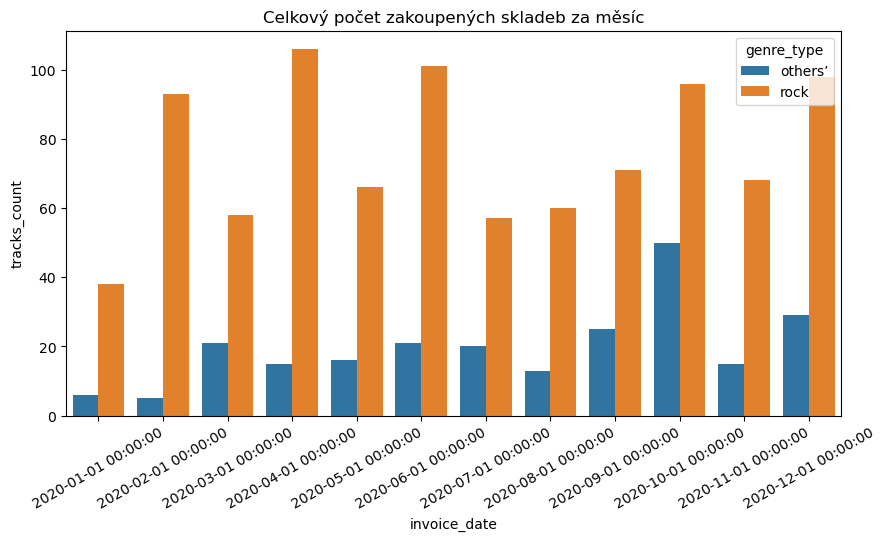

In [16]:
# Vytvářeme grafy se Seaborn
plt.figure(figsize=(10,5))
sns.barplot(x='invoice_date', y='tracks_count', hue='genre_type', data=tracks_count)
plt.title('Celkový počet zakoupených skladeb za měsíc')
plt.xticks(rotation=30)
plt.show()
           

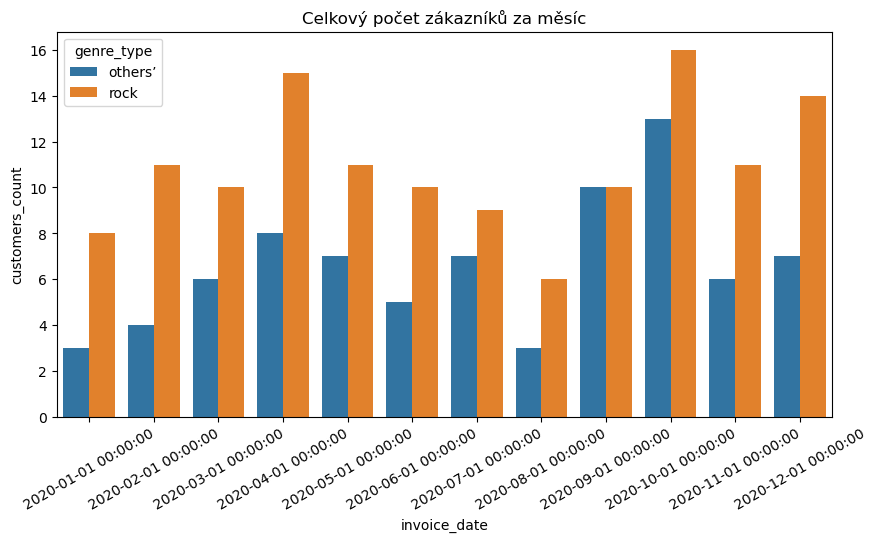

In [17]:
plt.figure(figsize=(10,5))
sns.barplot(x='invoice_date', y='customers_count', hue='genre_type', data=customers_count)
plt.title('Celkový počet zákazníků za měsíc')
plt.xticks(rotation=30)
plt.show()

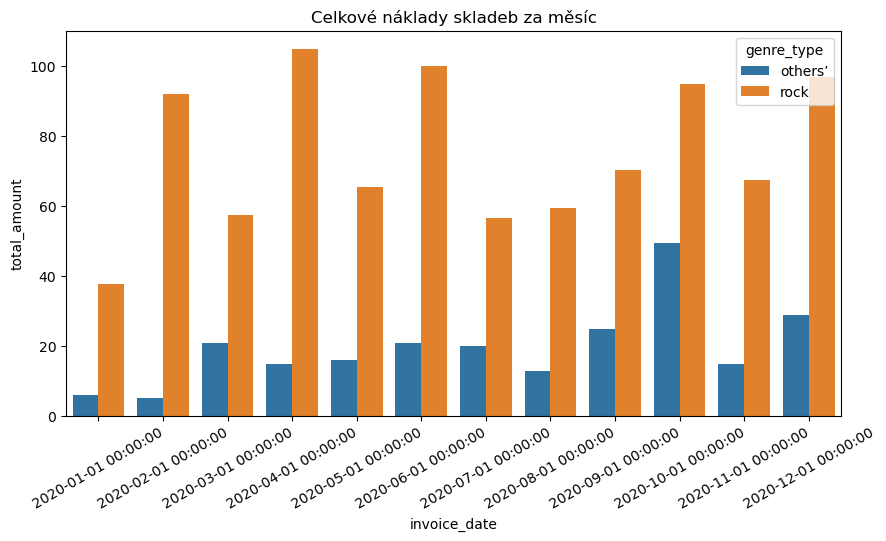

In [18]:
plt.figure(figsize=(10,5))
sns.barplot(x='invoice_date', y='total_amount', hue='genre_type', data=total_amount)
plt.title('Celkové náklady skladeb za měsíc')
plt.xticks(rotation=30)
plt.show()

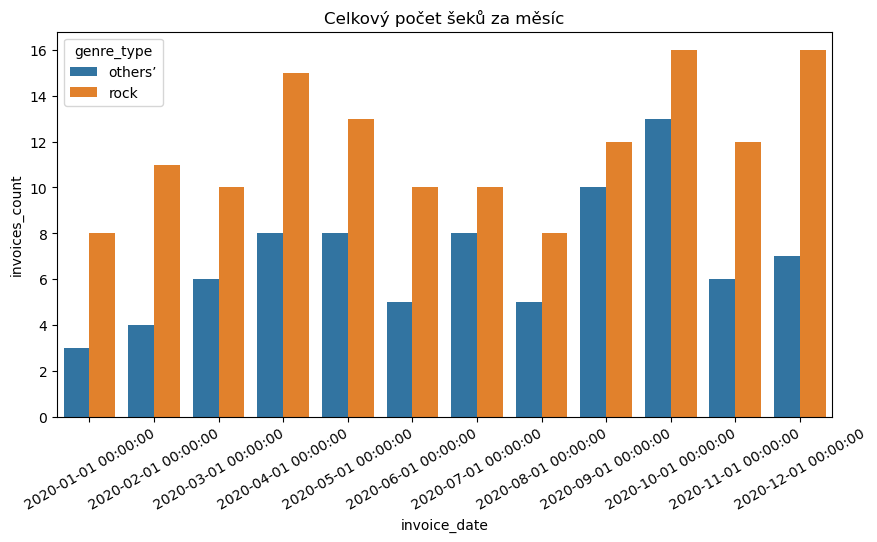

In [19]:
plt.figure(figsize=(10,5))
sns.barplot(x='invoice_date', y='invoices_count', hue='genre_type', data=invoices_count)
plt.title('Celkový počet šeků za měsíc')
plt.xticks(rotation=30)
plt.show()

In [20]:
# Závěr: je pozorována sezónnost při nákupu skladeb různých žánrů